<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/Object_Detection/Faster_R_CNN(2015)_%EB%AF%B8%EC%99%84%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 필요한 라이브러리 불러오기

In [ ]:
!pip install -U albumentations

     |████████████████████████████████| 81kB 4.8MB/s 
     |████████████████████████████████| 38.2MB 1.4MB/s 
     |████████████████████████████████| 952kB 34.6MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import torch.nn as nn
import torch
from torchvision.models import vgg16
import numpy as np
from torchvision.datasets import VOCDetection
import torchvision.datasets as dataset
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F
import torch.nn.init as init

from PIL import Image, ImageDraw, ImageFont
import os
import xml.etree.ElementTree as ET
from typing import Any, Callable, Dict, Optional, Tuple, List
import warnings
import tarfile
import collections
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
from torch import optim
import albumentations as A
from albumentations.pytorch import ToTensor
import os
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# VOC dataset 불러오기

In [ ]:
# VOC 2007 dataset을 저장할 위치
path2data = '/content/voc'
if not os.path.exists(path2data):
    os.mkdir(path2data)

In [ ]:
# VOC class names
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

In [ ]:
# PyTorch에서 제공하는 VOC dataset을 상속받아, custom dataset을 생성합니다.
class myVOCDetection(VOCDetection):
    def __getitem__(self, index):
        img = np.array(Image.open(self.images[index]).convert('RGB'))
        target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot()) # xml파일 분석하여 dict으로 받아오기

        targets = [] # 바운딩 박스 좌표
        labels = [] # 바운딩 박스 클래스

        # 바운딩 박스 정보 받아오기
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax'], classes.index(t['name'])

            targets.append(list(label[:4])) # 바운딩 박스 좌표
            labels.append(label[4])         # 바운딩 박스 클래스

        if self.transforms:
            augmentations = self.transforms(image=img, bboxes=targets)
            img = augmentations['image']
            targets = augmentations['bboxes']

        return img, targets, labels

    def parse_voc_xml(self, node: ET.Element) -> Dict[str, Any]: # xml 파일을 dictionary로 반환
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

In [ ]:
# train, validation dataset을 생성합니다.
train_ds = myVOCDetection(path2data, year='2007', image_set='train', download=True)
val_ds = myVOCDetection(path2data, year='2007', image_set='test', download=True)

# DataEncoder 정의하기

In [ ]:
class DataEncoder:
    def __init__(self):
        self.anchor_ratio = [0.5, 1, 2] # w/h
        self.anchor_sizes = [8, 16, 32] # scale
        self.anchor_number = len(self.anchor_ratio) * len(self.anchor_sizes) # 9
        self.stride = 16 # 입력 이미지 크기와 vgg16 마지막 피쳐맵 크기의 비율

    def encode_rpn(self, bboxs,labels):
        ctr_x = self.stride/2 # 8
        ctr_y = self.stride/2 # 8

        # 9개의 anchors
        anchors_template = np.zeros((9,4))

        for i, ratio in enumerate(self.anchor_ratio):
            for j, size in enumerate(self.anchor_sizes):
                # 앵커박스 너비와 높이
                w = size * np.sqrt(ratio) * self.stride
                h = size * np.sqrt(ratio) * self.stride

                # 앵커박스 좌표
                x1 = -w/2
                y1 = -h/2
                x2 = w/2
                y2 = h/2

                anchor = [x1,y1,x2,y2]
                anchors_template[i*len(self.anchor_ratio)+j]=anchor
        
        # 50x50 feature map의 모든 위치에 anchor 할당
        feature_map_size = 800 // 16

        # 중심 좌표
        ctr_x_all = np.arange(8, (feature_map_size + 1) * 16 - 8, 16)
        ctr_y_all = np.arange(8, (feature_map_size + 1) * 16 - 8, 16)

        ctr = np.zeros((feature_map_size, feature_map_size, 2), dtype=np.float32)

        for x in range(feature_map_size):
            for y in range(feature_map_size):
                ctr[x, y] = np.array([ctr_x_all[x], ctr_y_all[y]])


        # anchors -> (W//16, H//16, 9, 4)
        anchors = np.zeros((feature_map_size, feature_map_size, 9, 4))

        for x in range(feature_map_size):
            for y in range(feature_map_size):
                anchors[x, y] = (ctr[x, y] + anchors_template.reshape(-1, 2, 2)).reshape(-1, 4)

        # 앵커 박스에 labels 할당
        # 1) gt와 가장 높은 iou를 지닌 앵커박스에 positive 할당
        # 2) gt와 0.7 iou 이상을 지닌 앵커박스에 negative 할당

        # 입력 이미지를 벗어나는 앵커 제거
        anchors = anchors.reshape(-1, 4)

        index_inside = np.where((anchors[:, 0] >= 0) &
                            (anchors[:, 1] >= 0) &
                            (anchors[:, 2] <= 800) &
                            (anchors[:, 3] <= 800))[0]

        # 빈 레이블 생성
        label = np.empty((len(index_inside),), dtype=np.int32)
        label.fill(-1)

        valid_anchors = torch.Tensor(anchors[index_inside])

        # gt와 앵커의 iou 계산
        ious = self._box_iou(valid_anchors, bboxs, order='xyxy')

        ious = np.array(ious)
        bboxs = np.array(bboxs)
        labels = np.array(labels)
        valid_anchors = np.array(valid_anchors)

        # 각 gt에 대해 가장 높은 iou와 그에 해당하는 앵커박스
        gt_argmax_ious = ious.argmax(axis=0) # gt와 가장 높은 iou 인덱스
        gt_max_ious = ious[gt_argmax_ious, np.arange(len(bboxs))] # iou 추출

        # 각 앵커박스에 대해 가장 높은 iou와 그에 해당하는 gt
        argmax_ious = ious.argmax(axis=1)
        max_ious = ious[np.arange(ious.shape[0]), argmax_ious]

        # gt_max_ious를 가진 앵커박스 찾기
        gt_argmax_ious = np.where(ious == gt_max_ious)[0]

        pos_iou_threshold = 0.7 # positive
        neg_iou_threshold = 0.3 # negative


        label[max_ious < neg_iou_threshold] = 0
        label[gt_argmax_ious] = 1 # gt와 가장 높은 iou를 지닌 앵커박스
        label[max_ious >= pos_iou_threshold] = 1 # iou threshold 이상인 앵커박스 

        # positive, negative anchors sample
        # loss function 계산을 위해 256개의 앵커박스를 sample 합니다.
        # positive : negative = 1:1
        pos_ratio = 0.5
        n_sample = 256
        n_pos = pos_ratio * n_sample

        # positive
        pos_index = np.where(label == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(pos_index, size=len(pos_index) - n_pos, replace=False)
            label[disable_index] = -1

        # negative
        n_neg = n_sample - len(np.where(label==1)[0])

        neg_index = np.where(label == 0)[0]

        if len(neg_index) > n_neg:
            disable_index = np.random.choice(neg_index, size=len(neg_index) - n_neg, replace=False)
            label[disable_index] = -1

        # 앵커 박스 좌표 할당하기
        # gt와 앵커 박스의 offset을 계산합니다.
        max_iou_bbox = bboxs[argmax_ious]

        width = valid_anchors[:, 2] - valid_anchors[:, 0]
        height = valid_anchors[:, 3] - valid_anchors[:, 1]
        ctr_x = valid_anchors[:, 0] + width*0.5
        ctr_y = valid_anchors[:, 1] + height*0.5

        base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
        base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
        base_ctr_x = max_iou_bbox[:, 0] + base_height*0.5
        base_ctr_y = max_iou_bbox[:, 1] + base_width*0.5

        eps = np.finfo(height.dtype).eps
        height = np.maximum(height, eps)
        width = np.maximum(width, eps)

        dy = (base_ctr_y - ctr_y) / height
        dx = (base_ctr_x - ctr_x) / width
        dh = np.log(base_height / height)
        dw = np.log(base_width / width)

        anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()

        # valid anchor를 제외한 나머지를 채웁니다.
        anchor_labels = np.empty((len(anchors),), dtype=np.int32)
        anchor_labels.fill(-1)
        anchor_labels[index_inside] = label

        anchor_locations = np.empty((len(anchors), 4), dtype=np.float32)
        anchor_locations.fill(0)
        anchor_locations[index_inside] = anchor_locs

        return torch.Tensor(anchor_locations), torch.Tensor(anchor_labels)

    # encode된 값을 원래대로 복구 및 nms 진행
    def decode(self,loc_preds, cls_preds, input_size):
        cls_thresh = 0.5
        nms_thresh = 0.5

        input_size = torch.Tensor([input_size,input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size) # 앵커 박스 생성

        loc_xy = loc_preds[:,:2] # 결과값 offset 추출
        loc_wh = loc_preds[:,2:]

        xy = loc_xy * anchor_boxes[:,2:] + anchor_boxes[:,:2] # offset + anchor
        wh = loc_wh.exp() * anchor_boxes[:,2:]
        boxes = torch.cat([xy-wh/2, xy+wh/2], 1)

        score, labels = cls_preds.sigmoid().max(1)
        ids = score > cls_thresh
        ids = ids.nonzero().squeeze()
        keep = self._box_nms(boxes[ids], score[ids], threshold=nms_thresh) # nms
        return boxes[ids][keep], labels[ids][keep]

    
    # x1,y1,x2,y2 <-> cx,cy,w,h
    def _change_box_order(self, boxes, order):
        assert order in ['xyxy2xywh','xywh2xyxy']
        boxes = np.array(boxes)
        a = boxes[:,:2]
        b = boxes[:,2:]
        a, b = torch.Tensor(a), torch.Tensor(b)
        if order == 'xyxy2xywh':
            return torch.cat([(a+b)/2,b-a+1],1) # xywh
        return torch.cat([a-b/2, a+b/2],1) # xyxy

    # 두 박스의 iou 계산
    def _box_iou(self, box1, box2, order='xyxy'):
        if order == 'xywh':
            box1 = self._change_box_order(box1, 'xywh2xyxy')
            box2 = self._change_box_order(box2, 'xywh2xyxy')
        
        N = box1.size(0)
        M = box2.size(0)

        lt = torch.max(box1[:,None,:2], box2[:,:2])
        rb = torch.min(box1[:,None,2:], box2[:,2:])

        wh = (rb-lt+1).clamp(min=0)
        inter = wh[:,:,0] * wh[:,:,1]

        area1 = (box1[:,2]-box1[:,0]+1) * (box1[:,3]-box1[:,1]+1)
        area2 = (box2[:,2]-box2[:,0]+1) * (box2[:,3]-box2[:,1]+1)
        iou = inter / (area1[:,None] + area2 - inter)
        return iou

    # nms
    def _box_nms(self, bboxes, scores, threshold=0.5, mode='union'):
        x1 = bboxes[:,0]
        y1 = bboxes[:,1]
        x2 = bboxes[:,2]
        y2 = bboxes[:,3]

        areas = (x2-x1+1) * (y2-y1+1)
        _, order = scores.sort(0, descending=True) # confidence 순 정렬
        keep = []
        while order.numel() > 0:
            if order.numel() == 1:
                keep.append(order.data)
                break
            i = order[0] # confidence 가장 높은 anchor 추출
            keep.append(i) # 최종 detection에 저장

            xx1 = x1[order[1:]].clamp(min=x1[i])
            yy1 = y1[order[1:]].clamp(min=y1[i])
            xx2 = x2[order[1:]].clamp(max=x2[i])
            yy2 = y2[order[1:]].clamp(max=y2[i])

            w = (xx2-xx1+1).clamp(min=0)
            h = (yy2-yy1+1).clamp(min=0)
            inter = w*h

            if mode == 'union':
                ovr = inter / (areas[i] + areas[order[1:]] - inter)
            elif mode == 'min':
                ovr = inter / areas[order[1:]].clamp(max=areas[i])
            else:
                raise TypeError('Unknown nms mode: %s.' % mode)

            ids = (ovr<=threshold).nonzero().squeeze()
            if ids.numel() == 0:
                break
            order = order[ids+1]
        return torch.LongTensor(keep)

In [ ]:
encoder = DataEncoder()
loc_tar, cls_tar = encoder.encode_rpn(loc_targets, cls_targets)

print(loc_tar.shape, cls_tar.shape)

torch.Size([22500, 4]) torch.Size([22500])


# DataLoader 생성하기

In [ ]:
# collate_fn
def collate_fn(batch):
    encoder = DataEncoder()
    imgs = [x[0] for x in batch]
    boxes = [torch.Tensor(x[1]) for x in batch]
    labels = [torch.Tensor(x[2]) for x in batch]
    h,w = 800, 800 # 입력 이미지 크기
    num_imgs = len(imgs)
    inputs = torch.zeros(num_imgs, 3, h, w)

    loc_targets = []
    cls_targets = []

    # anchor box 생성
    for i in range(num_imgs):
        inputs[i] = imgs[i]
        # loc_target = [x,y,w,h]
        loc_target, cls_target = encoder.encode(boxes=boxes[i], labels=labels[i])
        loc_targets.append(loc_target)
        cls_targets.append(cls_target)
    return inputs, torch.stack(loc_targets), torch.stack(cls_targets)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


torch.Size([1, 3, 800, 800]) torch.Size([2, 5])


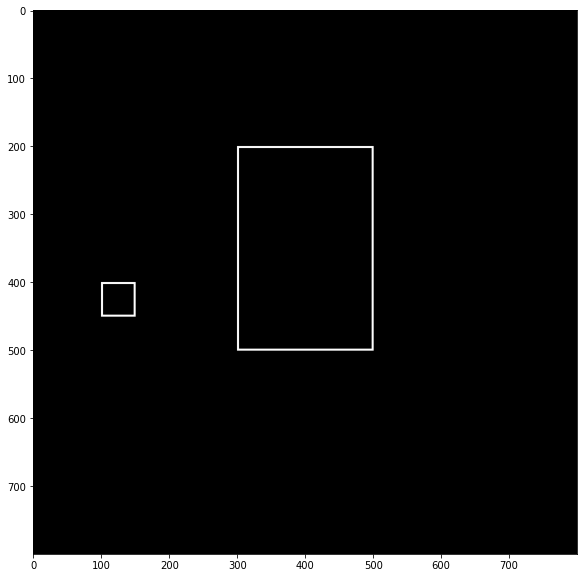

In [ ]:
image = torch.zeros(1, 3, 800, 800)
loc_targets = torch.empty(2, 4)
cls_targets = torch.empty(2, 1)
loc_targets[0] = torch.tensor([300, 200, 500, 500], dtype=float)
loc_targets[1] = torch.tensor([100, 400, 150, 450], dtype=float)
cls_targets[0], cls_targets[1] = 1, 2
torch.tensor(cls_targets, dtype=float)


def show(image, loc_targets, cls_targets):
    if type(image) == torch.Tensor:
        img = image.squeeze(0)
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    loc_targets = np.array(loc_targets)
    W, H = img.size

    for tg, label in zip(loc_targets, cls_targets):
        bbox = tg
        label = label

        draw.rectangle(((bbox[0], bbox[1]), (bbox[2], bbox[3])), width=3)
    plt.imshow(np.array(img))

plt.figure(figsize=(10,10))
show(image, loc_targets, cls_targets)

In [ ]:
encoder = DataEncoder()
loc_tar, obj = encoder.encode(loc_targets, cls_targets, input_size=(800,800))
print(loc_tar.shape, obj.shape)
obj = obj[obj>0.7]
print(obj)

torch.Size([22500])
torch.Size([22500, 4])
torch.Size([22500, 2])
torch.Size([22500, 1])
torch.Size([22500, 4]) torch.Size([500, 2])
tensor([0.7942])


# 모델 구축하기

In [ ]:
class feature_extractor(nn.Module):
    def __init__(self):
        super().__init__()

        # pre-trained VGG16
        self.backbone = nn.Sequential(*list(vgg16(pretrained=True).features))[:30]
    
    def forward(self,x):
        return self.backbone(x)

# check
x = torch.randn(1, 3, 800, 800).to(device)
model = feature_extractor().to(device)
output = model(x)
print(output.shape)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



torch.Size([1, 512, 50, 50])


In [ ]:
class RPN(nn.Module):
    def __init__(self, init_weights=True):
        super().__init__()

        mid_channels = 512
        in_channels = 512
        n_anchor = 9 # 앵커 박스 수

        # sliding layer
        self.conv1 = nn.Conv2d(in_channels, mid_channels,3,stride=1,padding=1)

        # RoI 좌표 예측, x1, y1, x2, y2
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor*4, 1, stride=1, padding=0)
        # RoI 객체 존재 유무 예측
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor*2, 1, stride=1, padding=0)
    
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)

        # anchor target와 같은 형태로 reformat
        # [batch, #anchor*H*W, coordinates]
        pred_anchor_locs = pred_anchor_locs.permute(0,2,3,1).contiguous().view(1,-1,4)

        # [batch, H, W, #anchor*object], object 존재 유무
        pred_cls_scores = pred_cls_scores.permute(0,2,3,1).contiguous()
        # [batch, #anchor*H*W], resion proposals를 만들때 사용
        objectness_scores = pred_cls_scores.view(1,50,50,9,2)[:,:,:,:,1].contiguous().view(1,-1)
        # [batch, #anchor*H*W, 2]
        pred_cls_scores = pred_cls_scores.view(1,-1,2)

        return pred_anchor_locs, pred_cls_scores, objectness_scores

    # 가중치 초기화
    def _initialize_weights(self):
        self.conv1.weight.data.normal_(0,0.01)
        self.conv1.bias.data.zero_()
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()

# check
x = torch.randn(1,512,50,50).to(device)
model = RPN().to(device)
loc, cls, score = model(x)
print(loc.shape)
print(cls.shape)
print(score.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
torch.Size([1, 22500])


In [ ]:
# RPN이 생성한 RoI를 입력값으로 취합니다.
class head(nn.Module):
    def __init__(self, anchors, indices_and_rois):
        super().__init__()
        self.size = (7,7)


        # RoI layer
        self.max_pool = nn.AdaptiveAvgPool2d(size)

        # Loc and Cls layer
        # 512*7*7 = 25088, RoI layer 출력값을 flatten
        roi_head_classifier = nn.Sequential(nn.Linear(25088,4096),
                                            nn.Linear(4096, 4096))
        
        # loc
        # (voc class 20 + background 1 * 4 coordinates)
        self.cls_loc = nn.Linear(4096, 21*4)
        
        # cls
        self.cls_score = nn.Linear(4096,21)

    


        



계획
dataloader로 target anchor 박스 생성

학습시에 rpn까지 학습해서 예측값 받음

train 함수에서 벌어지는 일
예측값과 생성한 anchor로 roi 만들고 nms 적용해서 fast r-cnn에 전달



# RPN 출력값으로 RoI 생성하는 함수

In [ ]:
# RPN 출력값으로 RoI를 생성합니다.
def generating_roI(pred_anchor_locs, pred_cls_scores, objectness_scores):
    # pred_anchor_loc, pred_cls_scores, objectness_score: RPN 출력값
    
    encoder = DataEncoder() # 앵커 박스를 생성하기 위해 DataEncoder 생성
    input_size = (800,800)

    nms_thresh = 0.7
    n_train_pre_nms = 12000 # nms 수행 전 roi 수
    n_train_post_nms = 2000 # nms 수행 후 roi 수
    n_test_pre_nms = 6000
    n_test_post_nms = 300
    min_size = 16 # stride

    input_size_tr = torch.Tensor([input_size, input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)

    # 앵커 박스 생성, [x,y,w,h]
    anchors = np.array(encoder._get_anchor_boxes(input_size_tr))
    
    # 앵커 박스 정보 추출
    anc_ctr_x = anchors[:,0]
    anc_ctr_y = anchors[:,1]
    anc_width = anchors[:,2]
    anc_height = anchors[:,3]

    pred_anchor_locs_np = pred_anchor_locs[0].data.numpy()
    objectness_scores_np = objectness_scores[0].data.numpy()

    # RPN 출력값 정보 추출
    dx = pred_anchor_locs_np[:,0]
    dy = pred_anchor_locs_np[:,1]
    dw = pred_anchor_locs_np[:,2]
    dh = pred_anchor_locs_np[:,3]

    # 앵커 박스와의 offset 계산
    ctr_x = dx * anc_width + anc_ctr_x
    ctr_y = dy * anc_height + anc_ctr_y
    w = np.exp(dw) + anc_width
    h = np.exp(dh) + anc_height

    # roi 생성, x1,y1,x2,y2
    roi = np.zeros(pred_anchor_locs_np.shape, dtype=anchors.dtype)
    roi[:,0] = ctr_x - 0.5*w
    roi[:,1] = ctr_y - 0.5*h
    roi[:,2] = ctr_x + 0.5*w
    roi[:,3] = ctr_y + 0.5*h

    # roi가 이미지 사이즈를 벗어나지 않도록 clip
    roi[:,0:4:2] = np.clip(roi[:,0:4:2],a_min=0,a_max=800)
    roi[:,1:4:2] = np.clip(roi[:,1:4:2],a_min=0,a_max=800)

    # 너비와 높이가 16보다 작은 roi 제거
    keep = np.where((h >= min_size) & (w >= min_size))[0]
    roi = roi[keep]
    score = objectness_scores_np[keep]

    # score가 높은 순서대로 정렬
    order = score.ravel().argsort()[::-1]
    
    # score 순으로 roi 12000개 추출
    order = order[:n_train_pre_nms]
    roi = torch.tensor(roi[order]) # (12000, 4)
    score = torch.tensor(score[order]) # (12000,)


    # nms 적용하기
    keep = encoder._box_nms(roi,score,threshold=nms_thresh)
    # 2000개 추출
    keep = keep[:n_train_post_nms]
    
    roi = roi[keep] # x1,y1,x2,y2
    return roi

In [ ]:
# check
x = torch.randn(1,512,50,50).to(device)
model = RPN().to(device)
loc, cls, score = model(x)
print(loc.shape)
print(cls.shape)
print(score.shape)

roi = generating_roI(loc,cls,score)
print(roi.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
torch.Size([1, 22500])
torch.Size([2000, 4])


# RoI sampling 함수
- Faster R-CNN은 2000개의 roi 중에서 positive 32, negative 96개를 sample 합니다.

In [ ]:
def roi_sampling(roi, boxes, labels):
    # roi = [x1,y1,x2,y2], loc_targets = [x,y,w,h]

    encoder = DataEncoder()


    # roi와 target 사이의 iou 계산
    rois = torch.tensor(roi)
    ious = np.array(encoder._box_iou(rois,boxes,order='xyxy'))
    
    # roi에 label 할당
    gt_assignment = ious.argmax(axis=1)
    max_iou = ious.max(axis=1)
    gt_roi_labels = labels[gt_assignment]
    
    # roi sample
    n_sample = 128
    pos_ratio = 0.25
    pos_iou_thresh = 0.5
    neg_iou_thresh_hi = 0.5
    neg_iou_thresh_lo = 0.0

    # positive sample
    pos_index = np.where(max_iou>=pos_iou_thresh)[0]
    pos_roi_per_this_image = n_sample * pos_ratio # 32
    # positive sample이 32개보다 적은 경우도 고려
    pos_roi_per_this_image = int(min(pos_roi_per_this_image, pos_index.size))
    if pos_index.size > 0:
        pos_index = np.random.choice(pos_index, size=pos_roi_per_this_image, replace=False)
    
    # negative sample
    neg_index = np.where((max_iou < neg_iou_thresh_hi) & (max_iou_thresh_lo))[0]
    neg_roi_per_this_image = n_sample - pos_roi_per_this_image
    if neg_index.size > 0:
        neg_index = np.random.choice(neg_index, size=neg_roi_per_this_image, replace=False)

    # positive, negative sample 결합
    keep_index = np.append(pos_index, neg_index)
    gt_roi_labels = gt_roi_labels[keep_index]
    gt_roi_labels[pos_roi_per_this_image:] = 0
    sample_roi = roi[keep_index]


    # 작업하기
    # head loss 계산을 위한 gt_sample 만들어야함



    return sample_roi

# 손실 함수

In [ ]:
# RPN Loss
def RPNLoss(loc_targets, cls_targets, loc_preds, cls_preds):
    loc_pred = loc_preds[0]
    cls_pred = cls_preds[0]

    # Cross Entropy Loss
    rpn_cls_loss = F.cross_entropy(cls_pred, cls_targets.long(), ignore_index=-1)

    # Regression Loss
    mask = cls_targets > 0 # 객체가 존재하는 경우
    mask_loc_preds = loc_pred[mask]
    maxk_loc_targets = loc_targets[mask]

    # smooth L1 Loss
    x = torch.abs(mask_loc_targets - mask_loc_preds)
    rpn_loc_loss = (x<1).float() * -.5 * x**2 + (x>1).float()*(x-0.5)

    # cls, reg Loss 결합하기
    rpn_lambda = 10
    N_reg = (gt_rpn_score>0).float().sum() # positive 수
    rpn_loc_loss = rpn_loc_loss.sum()/N_reg
    rpn_loss = rpn_cls_loss + rpn_lambda*rpn_loc_loss
    return rpn_loss

In [ ]:
# head loss
